<a href="https://colab.research.google.com/github/pratikpatil18/customer_lifetime_value_prediction/blob/main/clv_prediction_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Creating Dataframe of dataset

In [88]:
df=pd.read_csv("data.csv",encoding="unicode_escape")

In [89]:
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## Handling Missing Values


In [91]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [92]:
df['Description']=df['Description'].fillna('Unknown')

In [93]:
df['UnitPrice']=df['UnitPrice'].fillna(df['UnitPrice'].mean())
df['Country']=df['Country'].fillna('United Kingdom')

In [94]:
maxID=df['CustomerID'].max()
maxCount=df['CustomerID'].isna().sum()
newID=[maxID+ (i + 1) for i in range(maxCount)]
df.loc[df['CustomerID'].isna(), 'CustomerID'] = newID

df['CustomerID']

,CustomerID
0,17850.0
1,17850.0
2,17850.0
3,17850.0
4,17850.0
...,...
541904,12680.0
541905,12680.0
541906,12680.0
541907,12680.0


In [95]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


## Feature Selection and Extraction



In [96]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],errors='coerce')

In [97]:
df=df[['InvoiceNo','Quantity','InvoiceDate','UnitPrice','CustomerID']]

In [98]:
df.head()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,6,2010-12-01 08:26:00,2.55,17850.0
1,536365,6,2010-12-01 08:26:00,3.39,17850.0
2,536365,8,2010-12-01 08:26:00,2.75,17850.0
3,536365,6,2010-12-01 08:26:00,3.39,17850.0
4,536365,6,2010-12-01 08:26:00,3.39,17850.0


In [99]:
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]


In [100]:
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

In [101]:
df

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalAmount
0,536365,6,2010-12-01 08:26:00,2.55,17850.0,15.30
1,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34
2,536365,8,2010-12-01 08:26:00,2.75,17850.0,22.00
3,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34
4,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34
...,...,...,...,...,...,...
541904,581587,12,2011-12-09 12:50:00,0.85,12680.0,10.20
541905,581587,6,2011-12-09 12:50:00,2.10,12680.0,12.60
541906,581587,4,2011-12-09 12:50:00,4.15,12680.0,16.60
541907,581587,4,2011-12-09 12:50:00,4.15,12680.0,16.60


In [102]:
latest_date = df["InvoiceDate"].max()

In [103]:
recency_df = df.groupby("CustomerID")["InvoiceDate"].max().reset_index()
recency_df["Recency"] = (latest_date - recency_df["InvoiceDate"]).dt.days
recency_df = recency_df[["CustomerID", "Recency"]]

In [104]:
frequency_df = df.groupby("CustomerID")["InvoiceNo"].nunique().reset_index()
frequency_df.columns = ["CustomerID", "Frequency"]

In [105]:
monetary_df = df.groupby("CustomerID")["TotalAmount"].sum().reset_index()
monetary_df.columns = ["CustomerID", "Monetary"]

In [106]:
rfm = recency_df.merge(frequency_df, on="CustomerID").merge(monetary_df, on="CustomerID")
print(rfm.head())

   CustomerID  Recency  Frequency  Monetary
0     12346.0      325          1  77183.60
1     12347.0        1          7   4310.00
2     12348.0       74          4   1797.24
3     12349.0       18          1   1757.55
4     12350.0      309          1    334.40


In [107]:
rfm_data = rfm.copy()


scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data)


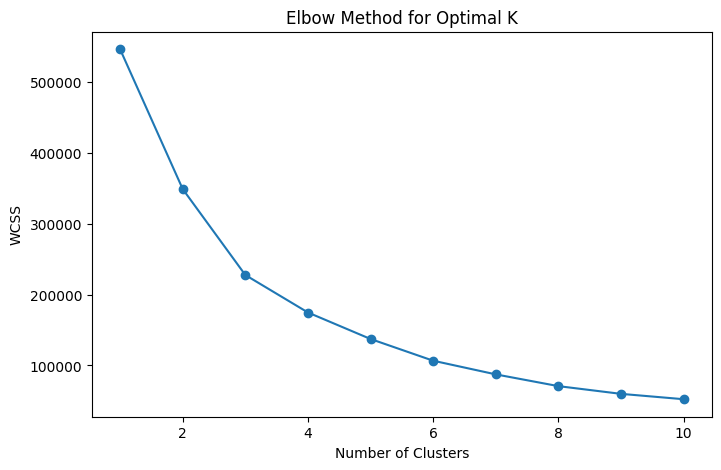

In [108]:

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal K")
plt.show()


In [109]:
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    df_new["index"] = df_new.index
    df = df.merge(df_new[[cluster_field_name, "index"]], on=cluster_field_name)
    df = df.drop(columns=[cluster_field_name])
    df = df.rename(columns={"index": cluster_field_name})
    return df

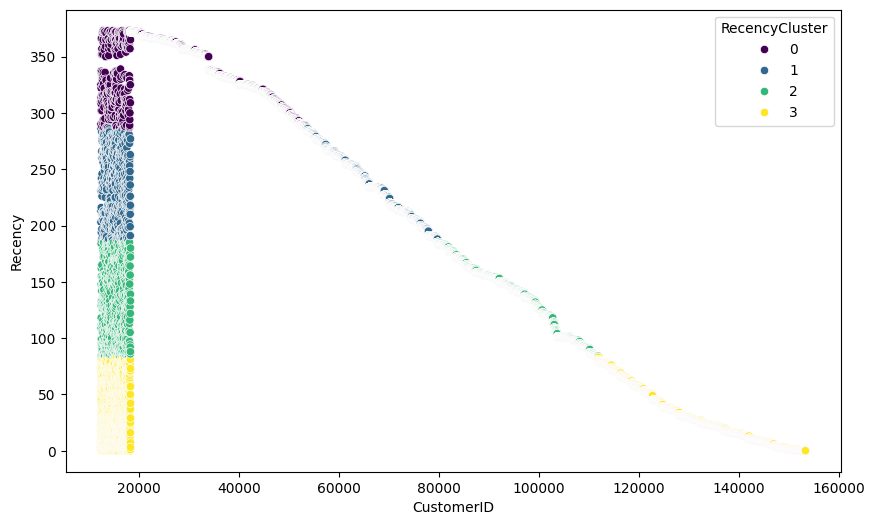

In [110]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm_data["RecencyCluster"] = kmeans.fit_predict(rfm_data[["Recency"]])
rfm_data = order_cluster("RecencyCluster", "Recency", rfm_data, ascending=False)

plt.figure(figsize=(10, 6))
sns.scatterplot(x="CustomerID", y="Recency", hue="RecencyCluster", palette="viridis", data=rfm_data)
plt.show()

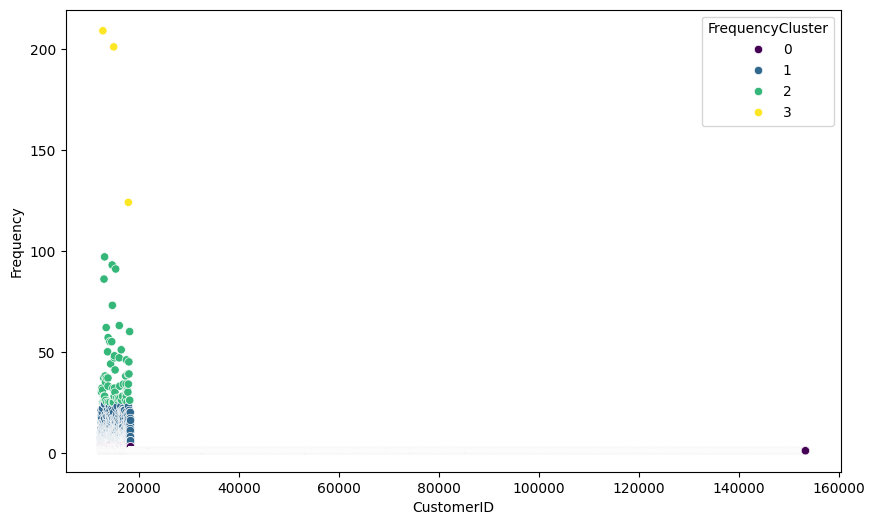

In [111]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm_data["FrequencyCluster"] = kmeans.fit_predict(rfm_data[["Frequency"]])
rfm_data = order_cluster("FrequencyCluster", "Frequency", rfm_data, ascending=True)


plt.figure(figsize=(10, 6))
sns.scatterplot(x="CustomerID", y="Frequency", hue="FrequencyCluster", palette="viridis", data=rfm_data)
plt.show()

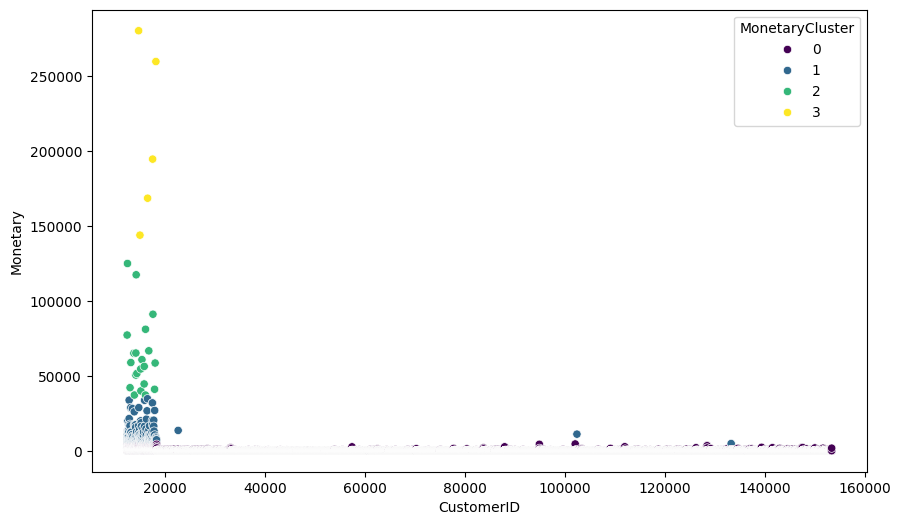

In [112]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm_data["MonetaryCluster"] = kmeans.fit_predict(rfm_data[["Monetary"]])
rfm_data = order_cluster("MonetaryCluster", "Monetary", rfm_data, ascending=True)

plt.figure(figsize=(10, 6))
sns.scatterplot(x="CustomerID", y="Monetary", hue="MonetaryCluster", palette="viridis", data=rfm_data)
plt.show()

   CustomerID  Recency  Frequency  Monetary  RecencyCluster  FrequencyCluster  \
0     12346.0      325          1  77183.60               0                 0   
1     12347.0        1          7   4310.00               3                 1   
2     12348.0       74          4   1797.24               3                 0   
3     12349.0       18          1   1757.55               3                 0   
4     12350.0      309          1    334.40               0                 0   

   MonetaryCluster  OverallScore    Segment  
0                2             2  Low-Value  
1                0             4  Mid-Value  
2                0             3  Mid-Value  
3                0             3  Mid-Value  
4                0             0  Low-Value  


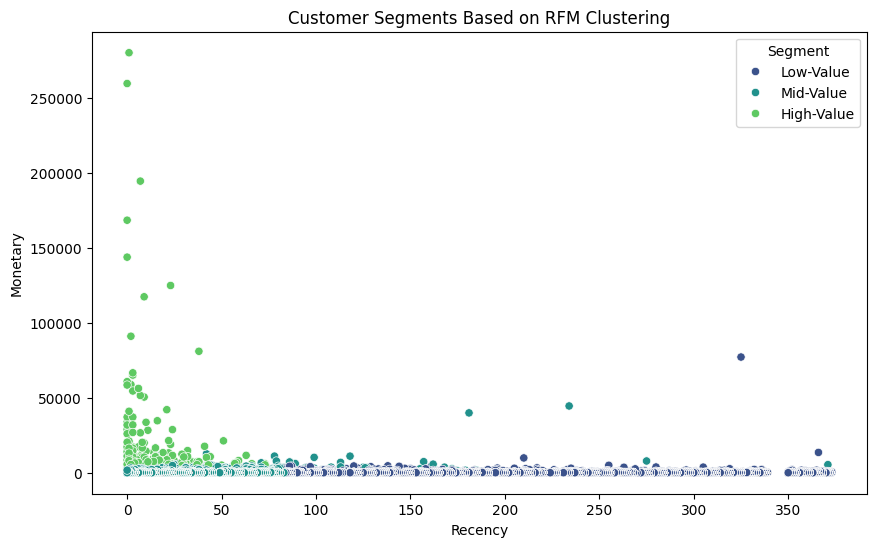

In [113]:
rfm_data["OverallScore"] = rfm_data["RecencyCluster"] + rfm_data["FrequencyCluster"] + rfm_data["MonetaryCluster"]

rfm_data["Segment"] = "Low-Value"
rfm_data.loc[rfm_data["OverallScore"] > 2, "Segment"] = "Mid-Value"
rfm_data.loc[rfm_data["OverallScore"] > 4, "Segment"] = "High-Value"

print(rfm_data.head())

plt.figure(figsize=(10, 6))
sns.scatterplot(x="Recency", y="Monetary", hue="Segment", palette="viridis", data=rfm_data)
plt.title("Customer Segments Based on RFM Clustering")
plt.show()


In [114]:
scaler = StandardScaler()
rfm_data_scaled = rfm_data.copy()
rfm_data_scaled[["Recency", "Frequency", "Monetary"]] = scaler.fit_transform(
    rfm_data_scaled[["Recency", "Frequency", "Monetary"]]
)

print(rfm_data_scaled.head())


   CustomerID   Recency  Frequency   Monetary  RecencyCluster  \
0     12346.0  1.235432  -0.069897  46.926345               0   
1     12347.0 -1.395133   3.964926   2.575525               3   
2     12348.0 -0.802444   1.947515   1.046261               3   
3     12349.0 -1.257109  -0.069897   1.022105               3   
4     12350.0  1.105528  -0.069897   0.155977               0   

   FrequencyCluster  MonetaryCluster  OverallScore    Segment  
0                 0                2             2  Low-Value  
1                 1                0             4  Mid-Value  
2                 0                0             3  Mid-Value  
3                 0                0             3  Mid-Value  
4                 0                0             0  Low-Value  


In [115]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report



X_class = rfm_data_scaled[["Recency", "Frequency", "Monetary"]]
y_class = rfm_data_scaled["Segment"]


X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)


clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_class, y_train_class)


y_pred_class = clf.predict(X_test_class)
print("Classification Accuracy:", accuracy_score(y_test_class, y_pred_class))
print(classification_report(y_test_class, y_pred_class))


Classification Accuracy: 0.999890158172232
              precision    recall  f1-score   support

  High-Value       1.00      1.00      1.00        59
   Low-Value       1.00      1.00      1.00     18686
   Mid-Value       1.00      1.00      1.00      8567

    accuracy                           1.00     27312
   macro avg       1.00      1.00      1.00     27312
weighted avg       1.00      1.00      1.00     27312



In [116]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

X = rfm_data_scaled[["Recency", "Frequency"]]
y = rfm_data_scaled["Monetary"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

evals = [(dtrain, 'train'), (dtest, 'eval')]
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=True
)

y_pred = xgb_model.predict(dtest)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost MAE: {mae}")
print(f"XGBoost R² Score: {r2}")
print(rfm_data_scaled.head())

[0]	train-rmse:1.03000	eval-rmse:0.75454
[1]	train-rmse:1.02974	eval-rmse:0.75423
[2]	train-rmse:1.02953	eval-rmse:0.75401
[3]	train-rmse:1.01096	eval-rmse:0.74263
[4]	train-rmse:0.98476	eval-rmse:0.73236
[5]	train-rmse:0.96731	eval-rmse:0.72262
[6]	train-rmse:0.94658	eval-rmse:0.71441
[7]	train-rmse:0.92943	eval-rmse:0.70222
[8]	train-rmse:0.92929	eval-rmse:0.70209
[9]	train-rmse:0.90880	eval-rmse:0.69893
[10]	train-rmse:0.90868	eval-rmse:0.69881
[11]	train-rmse:0.89066	eval-rmse:0.68794
[12]	train-rmse:0.89058	eval-rmse:0.68787
[13]	train-rmse:0.87769	eval-rmse:0.68151
[14]	train-rmse:0.87761	eval-rmse:0.68143
[15]	train-rmse:0.86212	eval-rmse:0.67176
[16]	train-rmse:0.85140	eval-rmse:0.66575
[17]	train-rmse:0.83976	eval-rmse:0.66051
[18]	train-rmse:0.83972	eval-rmse:0.66046
[19]	train-rmse:0.82650	eval-rmse:0.65549
[20]	train-rmse:0.82645	eval-rmse:0.65546
[21]	train-rmse:0.82641	eval-rmse:0.65544
[22]	train-rmse:0.81180	eval-rmse:0.64657
[23]	train-rmse:0.81176	eval-rmse:0.64655
[2

In [124]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

label_encoder = LabelEncoder()
rfm_data["SegmentEncoded"] = label_encoder.fit_transform(rfm_data["Segment"])

X = rfm_data[["Recency", "Frequency", "Monetary"]]
scaler = StandardScaler()
scaler.fit(X)

def predict_ltv(new_customer, scaler, clf, reg, label_encoder):
    feature_names = ["Recency", "Frequency", "Monetary"]
    new_customer_df = pd.DataFrame([new_customer], columns=feature_names)
    new_customer_scaled = scaler.transform(new_customer_df)
    segment_label = clf.predict(new_customer_scaled)[0]
    segment_name = label_encoder.inverse_transform([segment_label])[0]
    predicted_ltv = reg.predict(new_customer_scaled)[0]
    return segment_name, predicted_ltv

new_customer_data = [12, 1, 711.79]
segment, ltv = predict_ltv(new_customer_data, scaler, clf, reg, label_encoder)
print(f"Predicted Segment: {segment}, Predicted LTV: {ltv}")


Predicted Segment: Mid-Value, Predicted LTV: 743.1654395338044
